In [ ]:
import lmdb
import cv2
import os
import json
from tqdm import tqdm
from torch.utils.data import Dataset
import io
from PIL import Image

# Converting Your Data To LMDB

In [ ]:
def get_dir_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total_size += os.path.getsize(fp)
    return total_size

def create_lmdb_from_folders(img_dir, gt_dir, lmdb_path, ext="png"):

    lmdb_size = get_dir_size(img_dir)+get_dir_size(gt_dir)
    lmdb_size = round(lmdb_size * 1.05) # You may need to increase the size of the lmdb file if you get "Environment mapsize limit reached"
    print(lmdb_size/(1024*1024))
    
    # Create LMDB environment (1TB map size for safety)
    env = lmdb.open(lmdb_path, map_size=lmdb_size)

    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(f'.{ext}')]
    img_files.sort()
    print(f"Found {len(img_files)} image files")

    with env.begin(write=True) as txn:
        for idx, img_name in enumerate(img_files):
            
            base_name = os.path.splitext(img_name)[0]
            img_path = os.path.join(img_dir, img_name)
            gt_path = os.path.join(gt_dir, base_name + ".txt")
    
            # Read image as raw bytes (no quality loss)
            with open(img_path, "rb") as f:
                img_bin = f.read()
    
            # Read GT text
            with open(gt_path, "r", encoding="utf-8") as f:
                text = f.read().strip()
    
            # Keys
            img_key = f"image-{base_name}".encode()
            gt_key = f"label-{base_name}".encode()
    
            # Store into LMDB
            txn.put(img_key, img_bin)
            txn.put(gt_key, text.encode())
    
        # Save dataset size
        txn.put("num-samples".encode(), str(idx + 1).encode())
    
    print(f"✅ Created LMDB at: {lmdb_path}")


In [ ]:
split = "Test"

img_dir = f"../DATASETS/NorHandv3/{split}/line_splits/images"
print(img_dir)
gt_path = f"../DATASETS/NorHandv3/{split}/line_splits/gt_text"
lmdb_path = f"../DATASETS/NorHandv3/{split}/lmdb"


create_lmdb_from_folders(img_dir, gt_path, lmdb_path, "png")

../DATASETS/READ_2016/Test/image_lines
56.716312408447266
Found 1140 image files
✅ Created LMDB at: ../DATASETS/READ_2016/Test/lmdb


# Access Your Data from LMDB

üng. aines Ersamen Rats


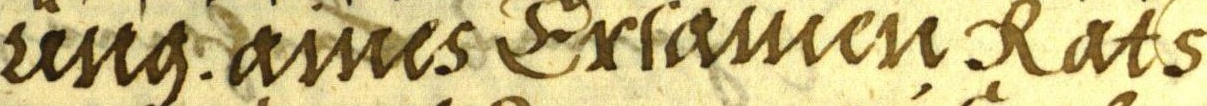

In [ ]:
import lmdb
import io
from PIL import Image

lmdb_path = f"../DATASETS/READ_2016/Training/lmdb"

env = lmdb.open(lmdb_path, readonly=True, lock=False)
keys = []
with env.begin() as txn:
    cursor = txn.cursor()  # create a cursor to iterate

    for key, value in cursor:
        key_str = key.decode()  # convert bytes -> string
        if key_str.startswith("image-"):
            keys.append(key_str[6:])

idx = 10
with env.begin() as txn:
    img_key = f"image-{keys[idx]}".encode()
    gt_key = f"label-{keys[idx]}".encode()

    img_bin = txn.get(img_key)
    label = txn.get(gt_key).decode()

print(label)

img = Image.open(io.BytesIO(img_bin)).convert("RGB")
img.show()
